In [1]:
!pip3 install xmltodict
import xmltodict
import json 
import os
import glob
import ast

You should consider upgrading via the '/home/evgenii/repos/indoor/Indoor/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
data_root = '/home/evgenii/repos/indoor/Dataset/'
stages = list(range(1, 7))

def get_ann_path(data_root: str, stage: int) -> str:
    return os.path.join(data_root, "annotation", f"annotation_s{stage}.xml")

get_ann_path(data_root, stages[0])

'/home/evgenii/repos/indoor/Dataset/annotation/annotation_s1.xml'

In [3]:
def get_images(data_root: str, stage: int) -> str:
    return sorted(glob.glob(os.path.join(data_root, f"sequence_{stage}", "*")), key=lambda s: int(s.split("_")[-1].split(".")[0]))

get_images(data_root, stages[0])[:10]

['/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_1.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_2.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_3.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_4.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_5.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_6.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_7.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_8.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_9.jpg',
 '/home/evgenii/repos/indoor/Dataset/sequence_1/frame_s1_10.jpg']

In [4]:
with open(get_ann_path(data_root, stages[0]), 'r') as bin_an:
    xml_ann = bin_an.read()
    annotations = ast.literal_eval(str(xmltodict.parse(xml_ann)).replace("@", ""))["dataset"]["images"]["image"]
    
    print(len(annotations))
    assert len(annotations) == len(get_images(data_root, stages[0]))
    print(annotations[0].keys())
    print(annotations[0])

148
dict_keys(['file', 'box'])
{'file': 'frame_s1_1.jpg', 'box': [{'top': '244', 'left': '500', 'width': '192', 'height': '99', 'label': 'exit'}, {'top': '358', 'left': '742', 'width': '218', 'height': '105', 'label': 'exit'}]}


In [5]:
def get_anns(data_root: str, stage: int) -> list:
    with open(get_ann_path(data_root, stage), 'r') as bin_an:
        xml_ann = bin_an.read()
        annotations = ast.literal_eval(str(xmltodict.parse(xml_ann)).replace("@", ""))["dataset"]["images"]["image"]
        return annotations

<h1>Statistics</h1>

In [6]:
from collections import Counter
from tqdm import tqdm
classes = []
for stage in tqdm(stages):
    stage_anns = get_anns(data_root, stage)
    for ann in stage_anns:
        boxes = ann.get("box")
        if boxes is None:
            continue
        else:
            if isinstance(boxes, list):
                for box in boxes:
                    classes.append(box["label"])
            else:
                classes.append(boxes["label"])
            
        

count = Counter(classes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.96it/s]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
count = np.array(count.most_common())

<BarContainer object of 7 artists>

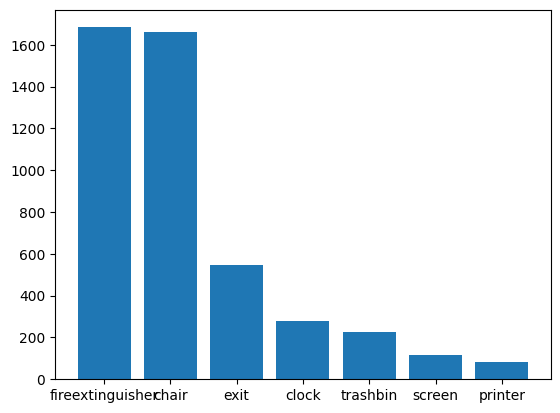

In [9]:
plt.bar(count[:, 0], count[:, 1].astype(np.int32))

Same as in <a href="https://arxiv.org/pdf/1807.03142.pdf">Link to Paper</a>

In [1]:
# Should have checked box sizes and rations for anchor based detectors :)
# Data Mean and std

<h1>Visualization</h1>

In [11]:
images_1 = get_images(data_root, stages[0])
annotations_1 = get_anns(data_root, stages[0])

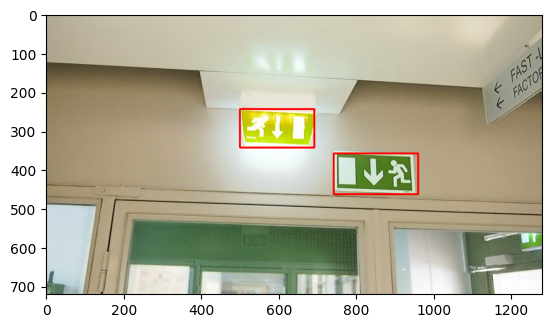

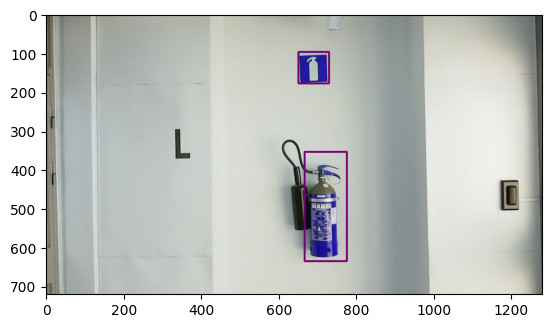

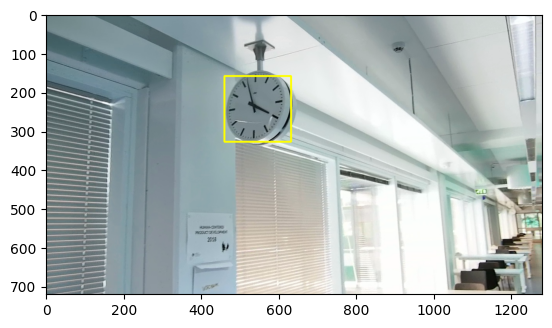

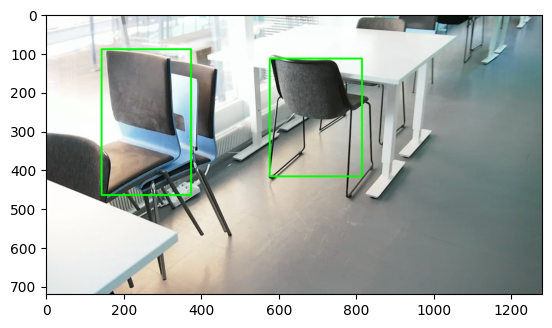

In [12]:
import cv2

color_mapping = {'fireextinguisher': (120, 0, 110),
                 'chair': (0, 255, 0),
                 'exit': (255, 0, 0),
                 'clock': (255, 255, 0),
                 'trashbin': (0, 255, 255),
                 'screen': (0, 0, 255),
                 'printer': (30, 200, 32)}

images_mapping = {value.split("/")[-1]: value for value in images_1}

def to_x1y1x2y2(box: dict) -> list:
    x1 = int(box["left"])
    y1 = int(box["top"])
    x2 = x1 + int(box["width"])
    y2 = y1 + int(box["height"])
    return x1, y1, x2, y2

for ann in annotations_1[:4]:
    image_path = images_mapping[ann["file"]]
    image = cv2.imread(image_path)
    boxes = ann.get("box")
    if boxes is None:
        print("kek")
        plt.imshow(image)
    else:
        if isinstance(boxes, list):
            for box in boxes:
                x1, y1, x2, y2 = to_x1y1x2y2(box)
                cv2.rectangle(image, (x1, y1), (x2, y2), color_mapping[box["label"]], 4)
            plt.imshow(image)
        else:
            x1, y1, x2, y2 = to_x1y1x2y2(boxes)
            cv2.rectangle(image, (x1, y1), (x2, y2), color_mapping[boxes["label"]], 4)
            plt.imshow(image)
    plt.show()
    

<h1>Process Data</h1>

In [15]:
import pandas as pd
new_ann_save_path = "/home/evgenii/repos/indoor/Dataset/annotations_processed/"

def create_ann(ann: dict, c: int) -> tuple[str, list]:
    new_ann = {}
    labels = []
    new_ann_path = os.path.join(new_ann_save_path, f"{c}.json")
    
    boxes = ann.get("box")
    
    if boxes is None:
        pass
    elif isinstance(boxes, list):
        new_ann["annotations"] = []
        for box in boxes:
            x1, y1, x2, y2 = to_x1y1x2y2(box)
            label = box["label"]
            labels.append(label)
            new_ann["annotations"].append({"box": [x1, y1, x2, y2], "label": label})
    elif isinstance(boxes, dict):
        new_ann["annotations"] = []
        x1, y1, x2, y2 = to_x1y1x2y2(boxes)
        label = boxes["label"]
        labels.append(label)
        new_ann["annotations"].append({"box": [x1, y1, x2, y2], "label": label})
    else:
        print("Something went wrong")
        
            
    
    with open(new_ann_path, 'w') as bin_f:
        json.dump(new_ann, bin_f)
    
    return new_ann_path, list(np.unique(labels))


dataframe_dict = {
    "image": [],
    "annotation": [],
    'fireextinguisher': [],
    'chair': [],
    'exit': [],
    'clock': [],
    'trashbin': [],
    'screen': [],
    'printer': [],
}
c = 0
for stage in tqdm(stages):
    images_mapping = {value.split("/")[-1]: value for value in get_images(data_root, stage)}
    annotations = get_anns(data_root, stage)
    for ann in annotations:
        c += 1
        image_path = images_mapping[ann["file"]]
        new_ann_path, labels = create_ann(ann, c)
        dataframe_dict["image"].append(image_path) 
        dataframe_dict["annotation"].append(new_ann_path)
        for key in list(dataframe_dict.keys())[2:]:
            if key in labels:
                dataframe_dict[key].append(1)
            else:
                dataframe_dict[key].append(0)
        
print(f"Created {c} annotations")
dataframe = pd.DataFrame(dataframe_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s]

Created 2213 annotations


In [19]:
dataframe.iloc[:, 2:].sum()

fireextinguisher    818
chair               850
exit                504
clock               277
trashbin            170
screen               94
printer              81
dtype: int64

In [20]:
dataframe.to_csv("full_data.csv", index=False)